<a href="https://colab.research.google.com/github/DannielM/Machine-Learning/blob/main/Desafio_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Experimento que avalia a melhor combinação entre hardware e software**

- A função é medir, avaliar e documentar o desempenho dessas tecnologias.

- Classificação de rótulos de cerveja.

- Usando Deep Learning

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import cv2
from tqdm import tqdm

# ***Baixando os nosso dados***

In [ ]:
import pathlib
dataset_url = "https://danielmulato.s3.amazonaws.com/second_dataset.tar.xz"
data_dir = tf.keras.utils.get_file('new_dataset', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [ ]:
print(data_dir)

/root/.keras/datasets/new_dataset


# ***O nosso dados estão configurados da seguinte forma:***


-  Bebidas
  - Becks
  - Brahma
  - BudWeiser
  - Corona
  - Skol 

# **Conjutos de dados** - *Imagens de Cervejas*

- As nossas imagens são **matrizes** de valores inteiros no intervalo de 0 a 4. Onde esses intervalos correspondem a classe de cervejas que cada imagem representa.


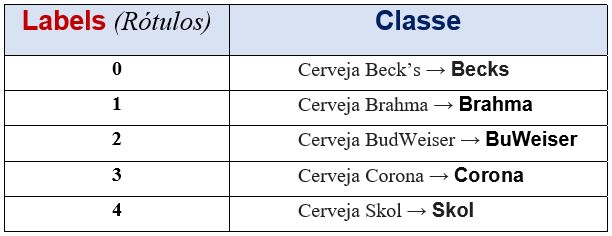

# ***Visualizando fotos de cada uma das cervejas***

In [ ]:
# Contando elementos da pasta zip
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

329


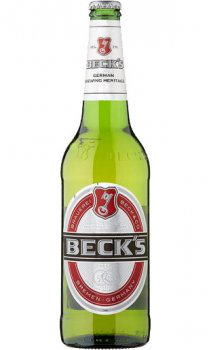

In [ ]:
# Exibindo a imagem da pasta Beck´s
Beck = list(data_dir.glob('Becks/*'))
PIL.Image.open(str(Beck[2]))

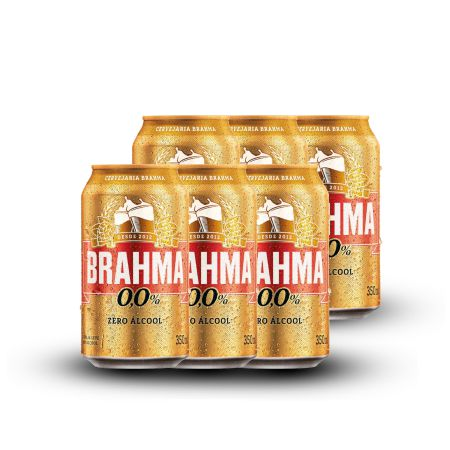

In [ ]:
# Exibindo a imagem da pasta Brahama
Brahama = list(data_dir.glob('Brahma/*'))
PIL.Image.open(str(Brahama[2]))

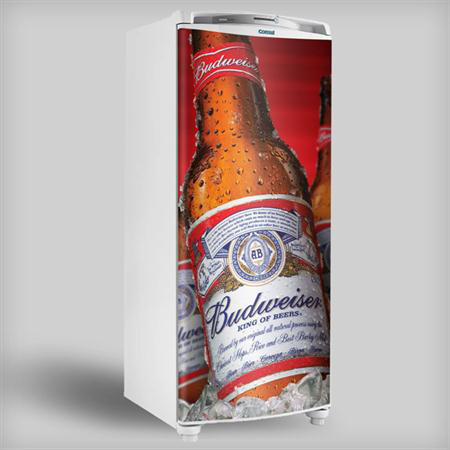

In [ ]:
# Exibindo a imagem da pasta cerveja BudWeiser
Budweiser = list(data_dir.glob('BudWeiser/*'))
PIL.Image.open(str(Budweiser[0]))

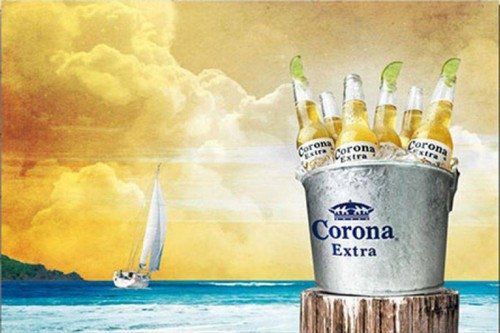

In [ ]:
# Exibindo a imagem da pasta cerveja cerveja Corona
Corona = list(data_dir.glob('Corona/*'))
PIL.Image.open(str(Corona[3]))

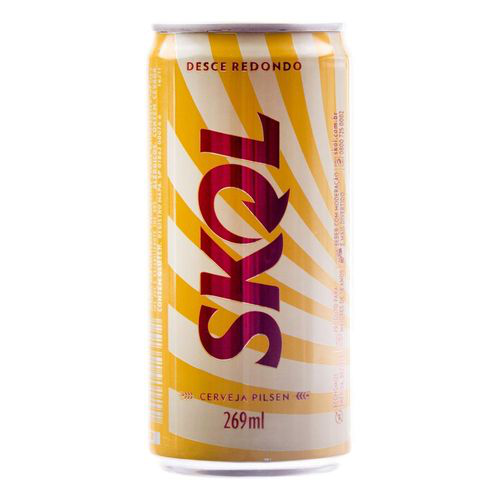

In [ ]:
# Exibindo a imagem da pasta cerveja cerveja Skol
Skol = list(data_dir.glob('Skol/*'))
PIL.Image.open(str(Skol[3]))

# **Definindo Parametros para o conjunto de dados**

- Usando **80%** das imagens para treinamento e **20%** para vailidação

In [ ]:
# Crie um conjunto de dados
# Definindo alguns parâmetros para o carregador:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
# É uma boa prática usar uma divisão de validação ao desenvolver seu modelo. 
# Vamos usar 80% das imagens para treinamento e 20% para validação.
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2, 
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 329 files belonging to 5 classes.
Using 264 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 329 files belonging to 5 classes.
Using 65 files for validation.


# **Verificando as classes das cervejas**

- Encontrando os nomes das classes no atributo class_names desses conjuntos de dados. 

- Eles correspondem aos nomes dos diretórios em ordem alfabética.

In [ ]:
class_names = train_ds.class_names
print(class_names)

['Becks', 'Brahma', 'BudWeiser', 'Corona', 'Skol']


# ***Vamos visualizar 16 imagens do conjunto de treinamento***

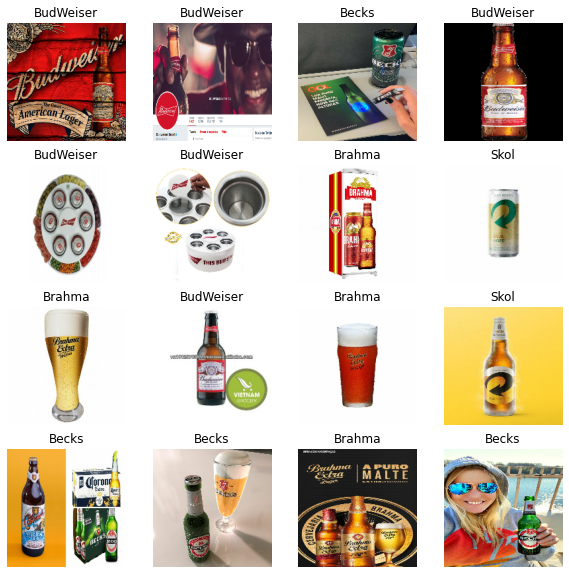

In [ ]:
# Vamos isualizar as primeiras imagens do conjunto de dados de treinamento.
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Aálisando o conjunto de dados unsado o **model.fit**

- O **image_batch** é um tensor da forma (32, 180, 180, 3).

- Este é um lote de 32 imagens de formato 180x180x3 (onde a última dimensão refere-se aos canais de cores RGB).

- O **label_batch** é um tensor da forma (32,) , esses são rótulos correspondentes às 32 imagens.

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(8, 180, 180, 3)
(8,)


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# ***Normalizando os dados***

In [ ]:
# Vamos padronize os nossos dados
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


# ***Criando e visualisando o modelo***

In [ ]:
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./256, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes) ])

In [ ]:
#
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(128, 128)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
    ])

# ***Compilando o modelo***

In [ ]:
# Compilando
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# Visualização das camadas da rede usando "summary" 
model.summary()

Model: "sequential_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_68 (Rescaling)     (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_90 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_91 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_92 (MaxPooling (None, 22, 22, 64)      

# ***Treinando o Modelo***

In [ ]:
 # Treinando
epochs=10
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10
9/9 [==============================] - 7s 779ms/step - loss: 1.4666 - accuracy: 0.3750 - val_loss: 1.4203 - val_accuracy: 0.3906
Epoch 2/10
9/9 [==============================] - 6s 716ms/step - loss: 1.2971 - accuracy: 0.4508
Epoch 3/10
9/9 [==============================] - 6s 716ms/step - loss: 1.0650 - accuracy: 0.5833
Epoch 4/10
9/9 [==============================] - 6s 714ms/step - loss: 0.8806 - accuracy: 0.6553
Epoch 5/10
9/9 [==============================] - 6s 716ms/step - loss: 0.6545 - accuracy: 0.7727
Epoch 6/10
9/9 [==============================] - 6s 719ms/step - loss: 0.4396 - accuracy: 0.8712
Epoch 7/10
9/9 [==============================] - 6s 716ms/step - loss: 0.4226 - accuracy: 0.8068
Epoch 8/10
9/9 [==============================] - 6s 717ms/step - loss: 0.4218 - accuracy: 0.8598
Epoch 9/10
9/9 [==============================] - 6s 718ms/step - loss: 0.2777 - accuracy: 0.9167
Epoch 10/10
9/9 [==============================] - 6s 718ms/step - loss: 0.1

# ***Visualizando do treinamento***

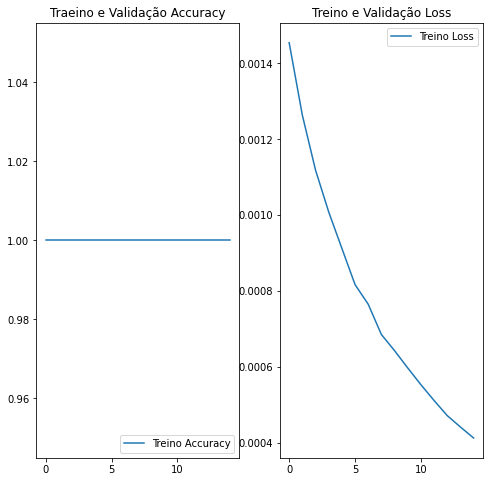

In [ ]:
#
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Treino Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Traeino e Validação Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Treino Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Treino e Validação Loss')
plt.show()

# ***# Vamos ver um outro modelo***

### Para essa modelo vamos modificar algumas caraterísticas, como:

- Ver uma imagem preto e branco

- Descofigurar a imagem

- Verificar as categórias

- Embaralhar os nossos dados

- Escolher um outro modelo e treinalo.


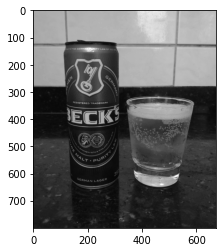

In [ ]:

DATADIR = "/root/.keras/datasets/new_dataset"

CATEGORIES = ["Becks", "Brahma", "BudWeiser", "Corona", "Skol"]

for category in CATEGORIES:  # Descrevendo as Cervejas
    path = os.path.join(DATADIR,category)  # Criando um diretório para as Cervejas
    for img in os.listdir(path):  # Interagindo as cervejas
        img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # Convertendo em uma matriz
        plt.imshow(img_array, cmap='gray')  #Representação gráfica
        plt.show()  # display!

        break  # Análisando apenas um tipo de cerveja e depois pedimos para parar.
    break  

    # Então é possível verificar a Cerveja "BEKS" é apresentada na imagem.

In [ ]:
# Exibindo a imagem em uma matriz
print(img_array)

[[167 167 168 ... 190 193 193]
 [167 167 168 ... 191 193 192]
 [167 167 168 ... 192 192 191]
 ...
 [ 31  31  30 ...  29  30  31]
 [ 38  36  34 ...  29  30  31]
 [ 44  42  38 ...  29  30  31]]


In [ ]:
# Obtendo informações da imagem
print(img_array.shape)

#Tem-se uma imagem de 800 de altura, 672 de largura e 3 canais de RGB

(800, 672)


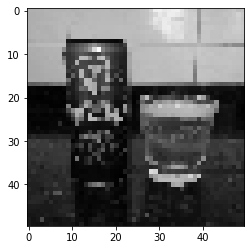

In [ ]:
# Reduzindo o tamanho da imagem
# Observe que ela ficou borrdada ou desconfigurada.
IMG_SIZE = 50

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap='gray')
plt.show()

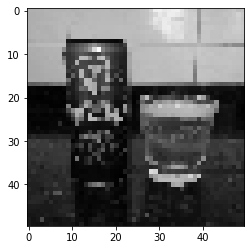

In [ ]:
# Reduzindo mais o tamanho da imagem
# Observe que ela ficou mais borrdada ou desconfigurada.
new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap='gray')
plt.show()

## **Criando os dados de treinamento**

In [ ]:
# Construido os dados de treinamento.
training_data = []

def create_training_data():
    for category in CATEGORIES:  # Categórias das Cervejas

        path = os.path.join(DATADIR,category)  
        class_num = CATEGORIES.index(category)  

        for img in tqdm(os.listdir(path)):  
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # Convertendo em matriz
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # Redimensionado e depois normaliza-los.
                training_data.append([new_array, class_num])  
            except Exception as e:  
                pass
           
create_training_data()

print(len(training_data))

100%|██████████| 64/64 [00:00<00:00, 148.34it/s]

328


## ***Embaralhando os dados***


- O motivo de embaralhar é para que algoritmo aprenda interpretar os dados de forma não sequencial. Sem o embarralhanento ele passaria por cada sub-diretório e aprenderia 1 modelo de cada vez.


In [ ]:
import random

random.shuffle(training_data)


In [ ]:
# Dados embaralhados
# Observe que as nossas classes em função dos Labels estão embaralhados,
for sample in training_data[:10]:
    print(sample[1])

1
0
1
2
3
2
4
3
4
4


In [ ]:
# Podemos ver o embaralhamento, pois temos várias amostras distintas
X = []
y = []

for features,label in training_data:
    X.append(features)
    y.append(label)

print(X[0].reshape(-1, IMG_SIZE, IMG_SIZE, 1))

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

[[[[169]
   [164]
   [161]
   ...
   [ 63]
   [140]
   [182]]

  [[170]
   [177]
   [179]
   ...
   [172]
   [208]
   [180]]

  [[184]
   [184]
   [182]
   ...
   [219]
   [210]
   [206]]

  ...

  [[141]
   [126]
   [124]
   ...
   [ 80]
   [158]
   [161]]

  [[181]
   [152]
   [141]
   ...
   [ 84]
   [ 74]
   [ 71]]

  [[201]
   [245]
   [210]
   ...
   [103]
   [106]
   [ 93]]]]


In [ ]:
# Salvando os dados
import pickle

pickle_out = open("X.pickle","wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle","wb")
pickle.dump(y, pickle_out)
pickle_out.close()

In [ ]:
IMG_SIZE = 50

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

y = np.array(y)

history = model.fit(X, y, batch_size=32, epochs=4, validation_split=0.1)

Epoch 1/4
10/10 [==============================] - 10s 1s/step - loss: -67088.3516 - accuracy: 0.3186 - val_loss: -148601.8594 - val_accuracy: 0.3636
Epoch 2/4
10/10 [==============================] - 10s 1s/step - loss: -242339.9844 - accuracy: 0.3186 - val_loss: -460544.1562 - val_accuracy: 0.3636
Epoch 3/4
10/10 [==============================] - 10s 1s/step - loss: -667106.6250 - accuracy: 0.3186 - val_loss: -1154952.8750 - val_accuracy: 0.3636
Epoch 4/4
10/10 [==============================] - 10s 1s/step - loss: -1520739.5000 - accuracy: 0.3186 - val_loss: -2535323.5000 - val_accuracy: 0.3636


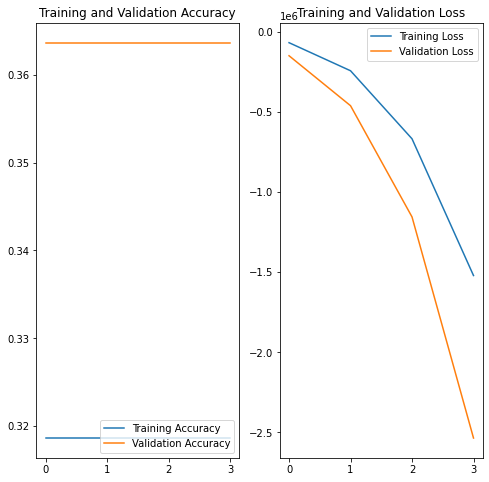

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(4)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

import pickle

pickle_in = open("X.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("y.pickle","rb")
y = pickle.load(pickle_in)

X = X/255.0

model = Sequential()

model.add(Conv2D(256, (3, 3), input_shape=X.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten()) 

model.add(Dense(64))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

y = np.array(y)
model.fit(X, y, batch_size=32, epochs=3, validation_split=0.3)

Epoch 1/3
8/8 [==============================] - 9s 1s/step - loss: -102.0165 - accuracy: 0.3013 - val_loss: -896.9315 - val_accuracy: 0.3636
Epoch 2/3
8/8 [==============================] - 9s 1s/step - loss: -2231.2261 - accuracy: 0.3057 - val_loss: -7330.1333 - val_accuracy: 0.3636
Epoch 3/3
8/8 [==============================] - 9s 1s/step - loss: -14896.2568 - accuracy: 0.3057 - val_loss: -33623.3828 - val_accuracy: 0.3636


In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard
import pickle
import time

NAME = "Cervejas"

pickle_in = open("X.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("y.pickle","rb")
y = pickle.load(pickle_in)

X = X/255.0

model = Sequential()

model.add(Conv2D(256, (3, 3), input_shape=X.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  
model.add(Dense(64))

model.add(Dense(1))
model.add(Activation('sigmoid'))

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'],
              )
y = np.array(y)
model.fit(X, y,
          batch_size=32,
          epochs=3,
          validation_split=0.3,
          callbacks=[tensorboard])

Epoch 1/3
1/8 [==>...........................] - ETA: 0s - loss: 0.6415 - accuracy: 0.3438WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
8/8 [==============================] - 9s 1s/step - loss: -163.9931 - accuracy: 0.3057 - val_loss: -1107.3977 - val_accuracy: 0.3636
Epoch 2/3
8/8 [==============================] - 9s 1s/step - loss: -3001.0425 - accuracy: 0.3057 - val_loss: -9407.8018 - val_accuracy: 0.3636
Epoch 3/3
8/8 [==============================] - 9s 1s/step - loss: -19970.7402 - accuracy: 0.3057 - val_loss: -43168.2383 - val_accuracy: 0.3636


# ***Fazendo um agrupamento dos dados***

In [ ]:
# Aumento de dados
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width, 3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1), ])

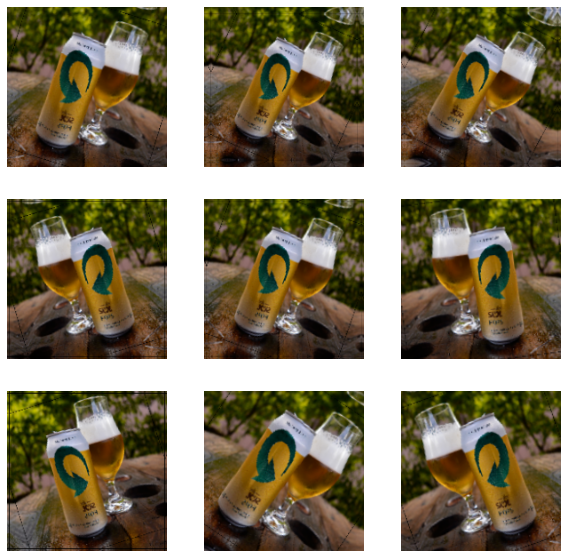

In [ ]:
# Vamos visualizar a aparência de alguns exemplos aumentados, aplicando o aumento de dados à mesma imagem várias vezes:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)])

# ***Compilando e Treinando o modelo***

In [ ]:
# Compilar e treinar o modelo
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# Compilando o modelo
model.summary()

Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_55 (Sequential)   (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_56 (Rescaling)     (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_78 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_79 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 45, 45, 64)      

In [ ]:
# TREINANDO
epochs = 15
history = model.fit(
  train_ds, validation_data=val_ds, epochs=15)

Epoch 1/15
9/9 [==============================] - 7s 791ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 4.2562 - val_accuracy: 0.5469
Epoch 2/15
9/9 [==============================] - 7s 723ms/step - loss: 0.0013 - accuracy: 1.0000
Epoch 3/15
9/9 [==============================] - 7s 724ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 4/15
9/9 [==============================] - 7s 725ms/step - loss: 0.0010 - accuracy: 1.0000
Epoch 5/15
9/9 [==============================] - 6s 722ms/step - loss: 9.1245e-04 - accuracy: 1.0000
Epoch 6/15
9/9 [==============================] - 7s 792ms/step - loss: 8.1678e-04 - accuracy: 1.0000
Epoch 7/15
9/9 [==============================] - 7s 724ms/step - loss: 7.6502e-04 - accuracy: 1.0000
Epoch 8/15
9/9 [==============================] - 6s 721ms/step - loss: 6.8516e-04 - accuracy: 1.0000
Epoch 9/15
9/9 [==============================] - 7s 723ms/step - loss: 6.4264e-04 - accuracy: 1.0000
Epoch 10/15
9/9 [==============================] - 6s 72

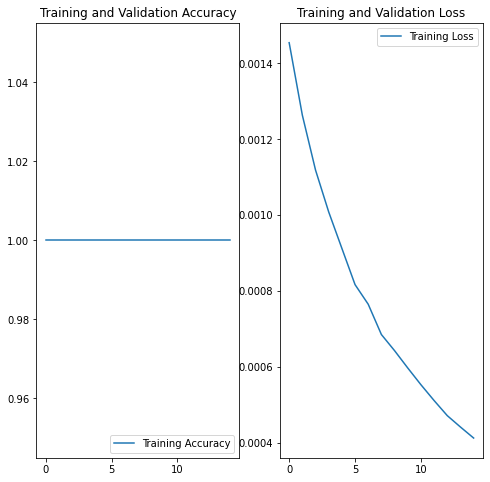

In [ ]:
# Visualização
#
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()